## First thing to do: Understand the data

Before this, let's import all the necessary libraries

In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

Now we are ready to see the data in the .mat file.\
1. Which are the variables?

In [2]:
data = loadmat('C_Mod_for_nn.mat')
print(data.keys())  

dict_keys(['__header__', '__version__', '__globals__', 'Greenwald_fraction', 'Mirnov_norm_btor', 'Te_peaking_ECE', 'beta_p', 'ip_error_normalized', 'kappa', 'li', 'lower_gap', 'n_equal_1_normalized', 'q95', 'radiated_fraction', 'shot', 'time', 'time_until_disrupt', 'v_loop', 'z_error', 'signal_names'])


2. Type of each variable?

In [3]:
variable_names = [] # Here I initialize some lists
variable_shapes = []
variable_types = []
for key, value in data.items():
    if key.startswith('__'): # I do not want the data which key starts with __, 
        #since they are constuctors and not real data. Whitou this i have an error
        continue #(="do not care about them")
    variable_names.append(key)
    variable_shapes.append(value.shape)
    variable_types.append(type(value).__name__) # without .__name__ I get "<class 'numpy.ndarray'>"
dflist = pd.DataFrame({  #to better see the data
    'Name': variable_names,
    'Shape': variable_shapes,
    'Type': variable_types
})
print(dflist)

                    Name        Shape     Type
0     Greenwald_fraction  (479692, 1)  ndarray
1       Mirnov_norm_btor  (479692, 1)  ndarray
2         Te_peaking_ECE  (479692, 1)  ndarray
3                 beta_p  (479692, 1)  ndarray
4    ip_error_normalized  (479692, 1)  ndarray
5                  kappa  (479692, 1)  ndarray
6                     li  (479692, 1)  ndarray
7              lower_gap  (479692, 1)  ndarray
8   n_equal_1_normalized  (479692, 1)  ndarray
9                    q95  (479692, 1)  ndarray
10     radiated_fraction  (479692, 1)  ndarray
11                  shot  (479692, 1)  ndarray
12                  time  (479692, 1)  ndarray
13    time_until_disrupt  (479692, 1)  ndarray
14                v_loop  (479692, 1)  ndarray
15               z_error  (479692, 1)  ndarray
16          signal_names      (13, 1)  ndarray


3. now we can see how the data look like (don't worry, I will not print 479692 lines for each variable!!!)

In [4]:
data_dict = {} # now I want a dict (I will need only the keys)

for key, value in data.items(): #same thing done before
    if key.startswith('__'):
        continue
    flattened_value = value.flatten() #IF NOT flatten -> Error:all the input arrays must have same number of dimensions, 
    # but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)
    data_dict[key] = flattened_value
# all arrays must be of the same length
    max_len = max(len(v) for v in data_dict.values())
    for key, value in data_dict.items():
        if len(value) < max_len:
            # Gli array + corti li devo riempire fino alla lungh del piu grosso
            pad = np.full((max_len - len(value)), np.nan) # If I put 'NaN', it will not be considered later
            data_dict[key] = np.concatenate([value, pad])
            
dfdic = pd.DataFrame(data_dict)
print(dfdic.head(200)) #let see the first 200 rows


     Greenwald_fraction  Mirnov_norm_btor  Te_peaking_ECE    beta_p  \
0          2.616714e-01          1.239055             NaN  0.147276   
1          1.936365e-01          1.153987             NaN  0.199118   
2          3.123977e-21          3.540942             NaN -0.014039   
3          1.853891e-01          0.208537             NaN  0.001086   
4          1.804675e-01          0.194072             NaN  0.024498   
..                  ...               ...             ...       ...   
195        1.824545e-01          0.163390        2.136794  0.097235   
196        1.870865e-01          0.129039        2.130717  0.100728   
197        1.891070e-01          0.373102        1.966626  0.112711   
198        1.989131e-01          3.504087             NaN  0.057663   
199        1.012282e-22          4.757826             NaN  0.000000   

     ip_error_normalized     kappa        li  lower_gap  n_equal_1_normalized  \
0              -0.155933  1.572284  1.440702   0.071738           

We can also print a single variable

In [5]:
Greenw = data['Greenwald_fraction']
print(Greenw)

[[2.61671424e-01]
 [1.93636477e-01]
 [3.12397703e-21]
 ...
 [1.67424858e-01]
 [1.69788092e-01]
 [1.66034207e-01]]


Good, it seems that there are tons of NaN values: we can see them better.\
4. See how many Null values there are

In [6]:
nans = dfdic.isna().sum()
print("Number of missing values for each column:")
print(nans)

tot_nan = dfdic.isna().sum().sum()
print(f"Total number of missing values: {tot_nan}")

Number of missing values for each column:
Greenwald_fraction         455
Mirnov_norm_btor            72
Te_peaking_ECE          141680
beta_p                       0
ip_error_normalized          0
kappa                        1
li                           0
lower_gap                    0
n_equal_1_normalized         0
q95                          3
radiated_fraction          532
shot                         0
time                         0
time_until_disrupt      400863
v_loop                       0
z_error                      0
signal_names            479679
dtype: int64
Total number of missing values: 1023285


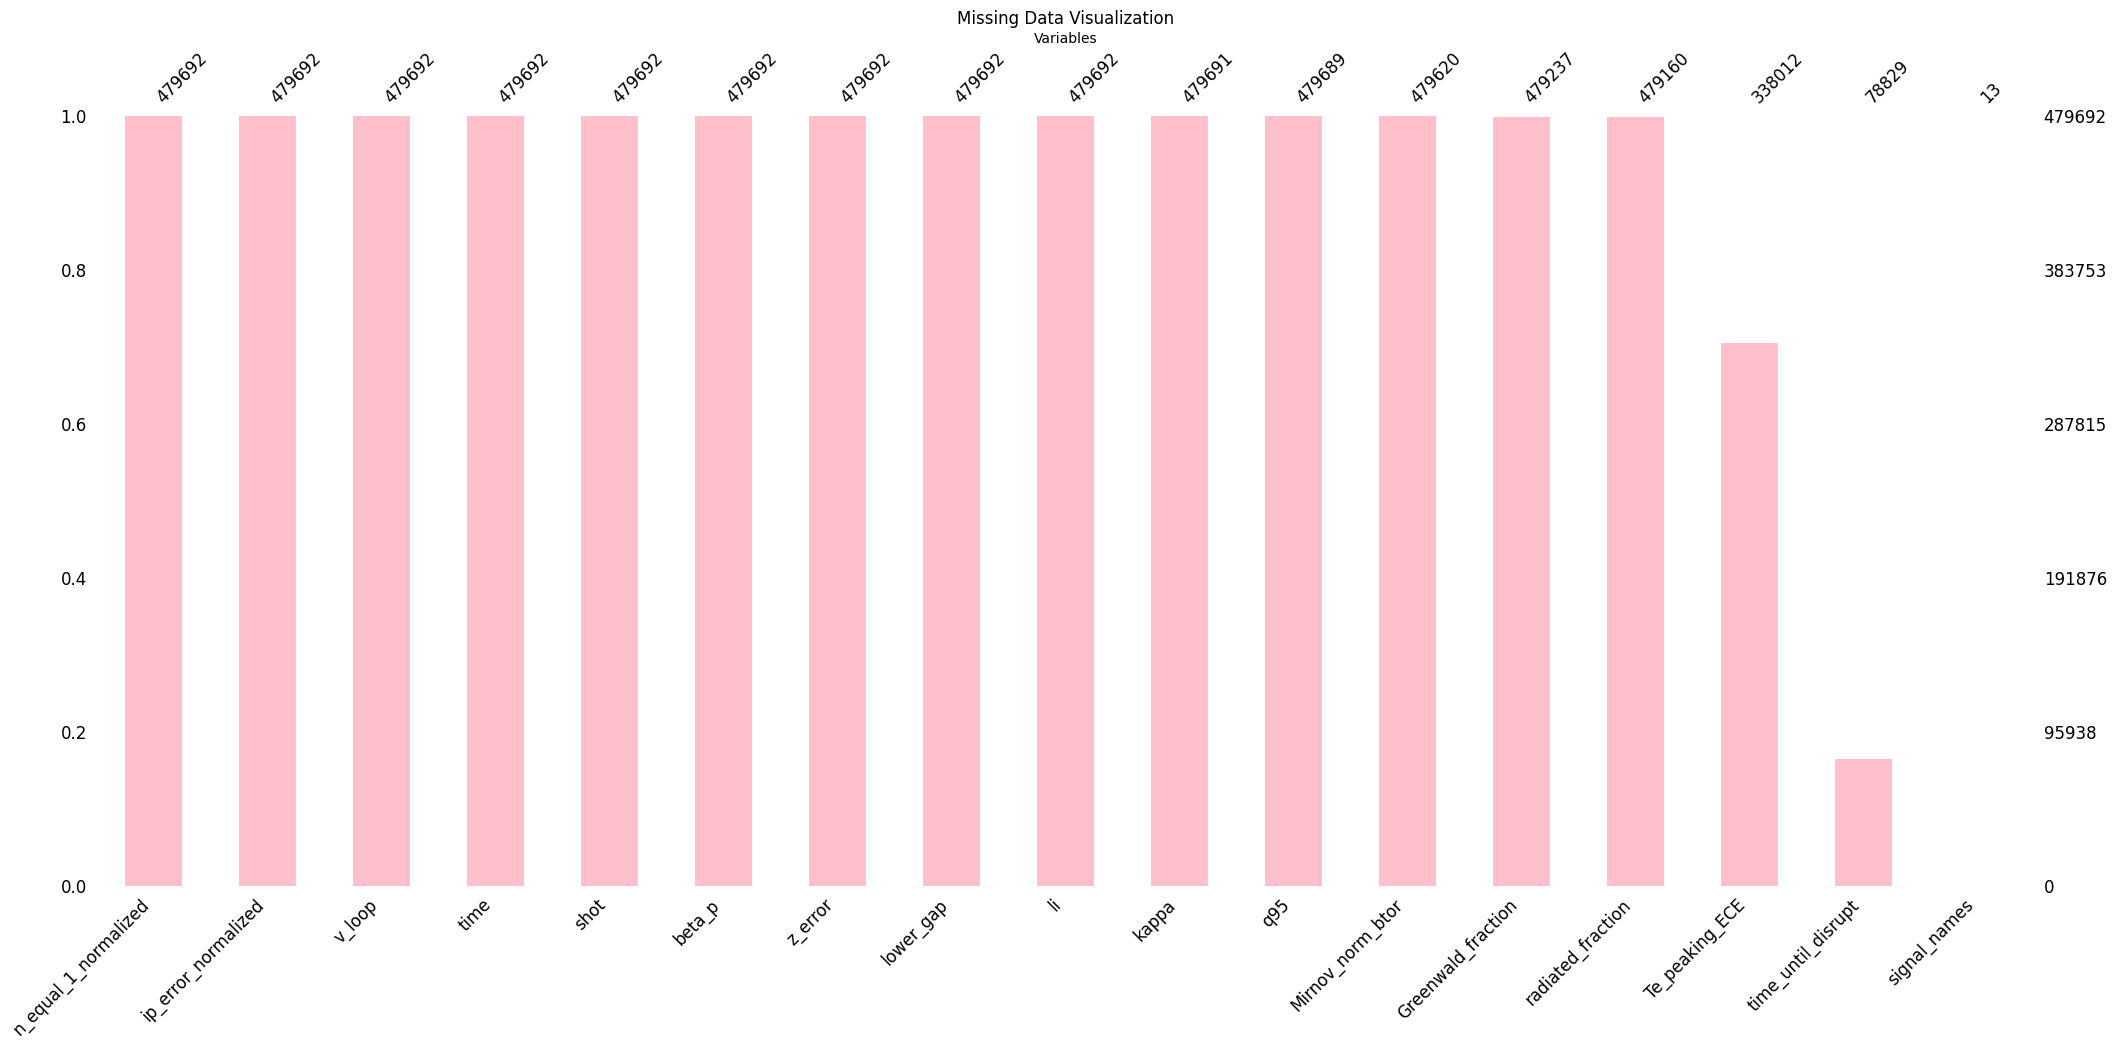

In [7]:
plt.figure(figsize=(14, 6))
msno.bar(dfdic, fontsize=12, color="pink", sort="descending")
plt.title('Missing Data Visualization')
plt.xlabel('Variables')
plt.ylabel('Data Availability')
plt.show()

Now We know how are the data:

### Let us do the model

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.svm import SVC

First model: Random Forest

Train set: (63063, 13) (63063,)
Test set: (15766, 13) (15766,)


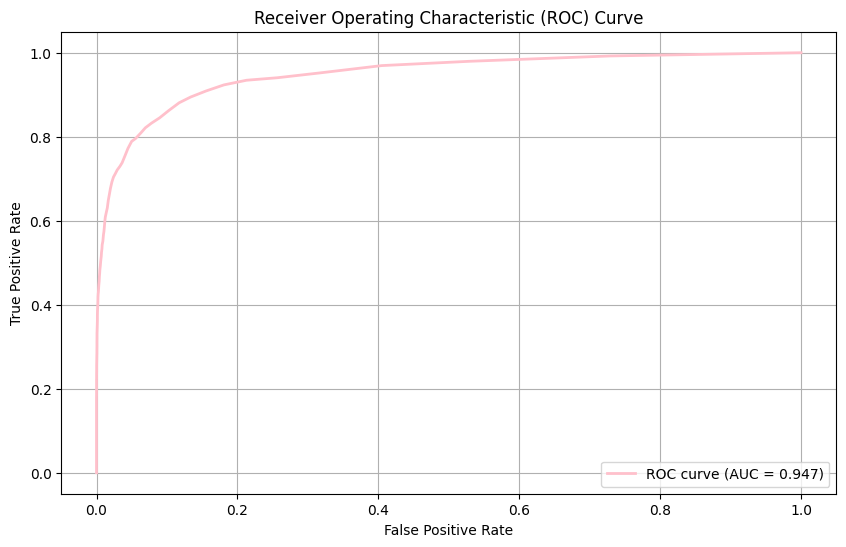

ROC Curve Data:
       fpr_rf    tpr_rf  threshold
0    0.000000  0.000000        inf
5    0.000000  0.154043       0.96
10   0.000069  0.184681       0.91
15   0.000069  0.216170       0.86
20   0.000206  0.246809       0.81
25   0.000411  0.274894       0.76
30   0.000617  0.306383       0.71
35   0.000891  0.342128       0.66
40   0.001302  0.379574       0.61
45   0.001919  0.402553       0.56
50   0.002878  0.435745       0.51
55   0.004523  0.475745       0.46
60   0.006237  0.508085       0.41
65   0.009047  0.551489       0.36
70   0.012473  0.608511       0.31
75   0.019738  0.676596       0.26
80   0.033171  0.729362       0.21
85   0.055445  0.795745       0.16
90   0.102392  0.862128       0.11
95   0.212871  0.934468       0.06
100  0.729354  0.992340       0.01


In [9]:
keys = ['Greenwald_fraction', 'Mirnov_norm_btor', 'Te_peaking_ECE', 'beta_p',
        'ip_error_normalized', 'kappa', 'li', 'lower_gap', 'n_equal_1_normalized',
        'q95', 'radiated_fraction', 'v_loop', 'z_error', 'shot', 'time', 'time_until_disrupt']
data_dict = {key: data[key].flatten() if data[key].ndim > 1 else data[key] for key in keys}


df = pd.DataFrame(data_dict)
df = df.dropna(subset=['time_until_disrupt']) #drop if NaN
features = ['Greenwald_fraction', 'Mirnov_norm_btor', 'Te_peaking_ECE', 'beta_p',
             'ip_error_normalized', 'kappa', 'li', 'lower_gap', 'n_equal_1_normalized',
             'q95', 'radiated_fraction', 'v_loop', 'z_error']
X = df[features]
y = df['time_until_disrupt'].apply(lambda x: 1 if x < 0.03 else 0) 
#lambda defines a anonym function. it can be substituted with an explicit function:
#lambda x: 1 if x < 0.03 else 0 is equal to 
# def function(x):
#    return 1 if x < 0.03 else 0, and then apply(function)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# random state should be fixed to a number to guarantee reproducibility
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


#In generale, it is better to "Standardize features by removing the mean and scaling to unit variance"
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

y_prob = rfc.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='pink',  linewidth=2, label=f'ROC curve (AUC = {roc_auc_rf:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
roc_df = pd.DataFrame({
    'fpr_rf': fpr_rf,
    'tpr_rf': tpr_rf,
    'threshold': thresholds
})
roc_df_filtered = roc_df.iloc[::5]
print("ROC Curve Data:")
print(roc_df_filtered) 

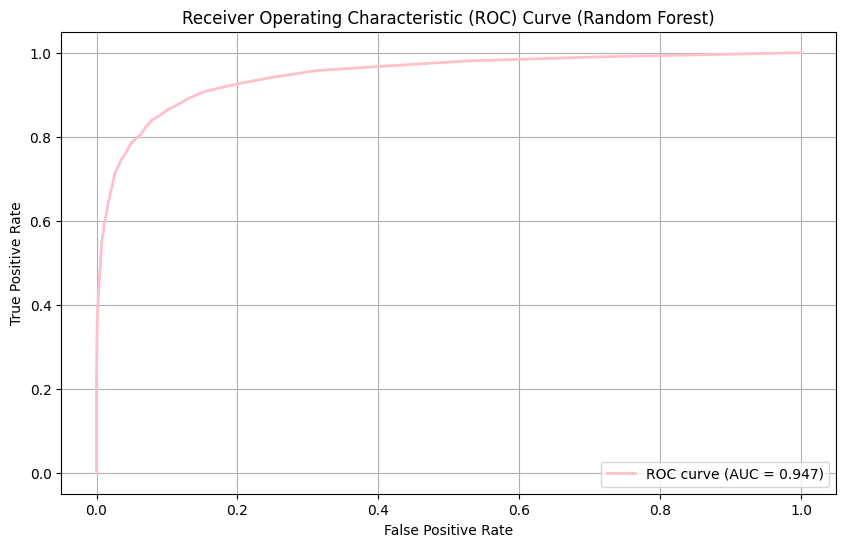

ROC Curve Data:
      fpr_rf    tpr_rf  threshold
0   0.000000  0.000000        inf
5   0.000000  0.155745       0.96
10  0.000000  0.183830       0.91
15  0.000000  0.219574       0.85
20  0.000137  0.244255       0.80
25  0.000411  0.302979       0.72
30  0.000685  0.331915       0.67
35  0.001234  0.366809       0.62
40  0.002056  0.400000       0.57
45  0.002810  0.428085       0.52
50  0.004318  0.469787       0.47
55  0.005826  0.510638       0.42
60  0.008430  0.560851       0.36
65  0.013364  0.611064       0.31
70  0.020081  0.669787       0.26
75  0.031869  0.731915       0.21
80  0.062230  0.804255       0.15
85  0.113632  0.874894       0.10
90  0.251936  0.942128       0.05
95  1.000000  1.000000       0.00


In [10]:
# Grouped by related categories
temporal_features = ['time', 'time_until_disrupt']
plasma_magnetic_properties = ['Greenwald_fraction', 'Mirnov_norm_btor', 'Te_peaking_ECE', 'beta_p', 'q95']
control_shape_variables = ['ip_error_normalized', 'kappa', 'li', 'lower_gap', 'n_equal_1_normalized', 'z_error']
other_diagnostics = ['radiated_fraction', 'v_loop']
shot_information = ['shot']

# Combine all features
all_keys = temporal_features + plasma_magnetic_properties + control_shape_variables + other_diagnostics + shot_information

# Construct data dictionary with flattening for multidimensional arrays
data_dict = {key: data[key].flatten() if data[key].ndim > 1 else data[key] for key in all_keys}

# Create a dataframe and drop rows with missing 'time_until_disrupt'
df = pd.DataFrame(data_dict)
df = df.dropna(subset=['time_until_disrupt'])

# Define features (excluding time-related and shot-specific variables)
features = plasma_magnetic_properties + control_shape_variables + other_diagnostics

# Target variable: Binary classification based on 'time_until_disrupt' threshold
y = df['time_until_disrupt'].apply(lambda x: 1 if x < 0.03 else 0)

# Split data into training and testing sets
X = df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (mean = 0, variance = 1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

# Predict probabilities of the positive class
y_prob = rfc.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='pink', linewidth=2, label=f'ROC curve (AUC = {roc_auc_rf:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Random Forest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# ROC Curve Data - displaying at intervals
roc_df = pd.DataFrame({
    'fpr_rf': fpr_rf,
    'tpr_rf': tpr_rf,
    'threshold': thresholds
})
roc_df_filtered = roc_df.iloc[::5]
print("ROC Curve Data:")
print(roc_df_filtered)


Similar thing using SVC

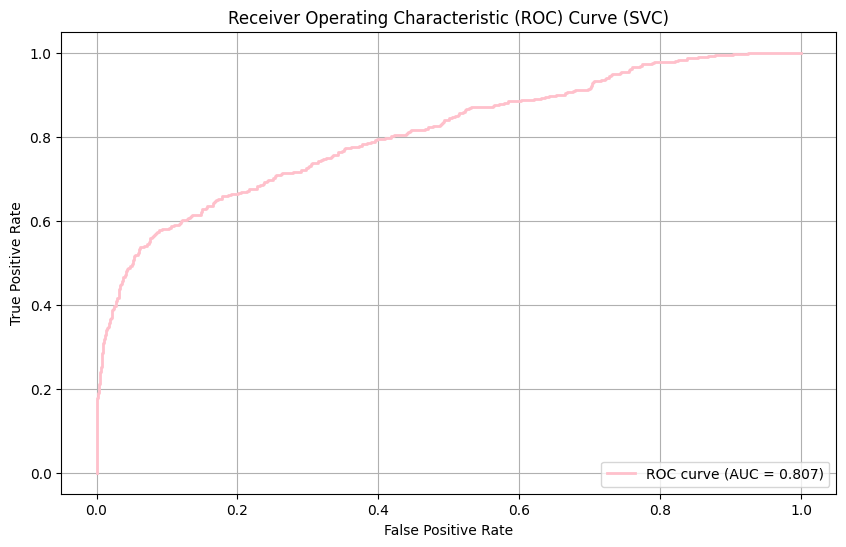

ROC Curve Data:
      fpr_SVC   tpr_SVC  threshold
0    0.000000  0.000000        inf
5    0.000226  0.105121   0.959739
10   0.000453  0.126685   0.875619
15   0.000792  0.134771   0.783886
20   0.001019  0.169811   0.482465
..        ...       ...        ...
535  0.774256  0.970350   0.031013
540  0.791803  0.978437   0.030437
545  0.838786  0.983827   0.028387
550  0.868221  0.991914   0.026884
555  0.924827  0.997305   0.021068

[112 rows x 3 columns]


In [11]:
df = df.dropna(subset=['time_until_disrupt'])
df = df.dropna()
X = df[features]
y = df['time_until_disrupt'].apply(lambda x: 1 if x < 0.03 else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
svc_model = SVC(kernel='rbf',probability=True)
svc_model.fit(X_train, y_train)

y_prob = svc_model.predict_proba(X_test)[:, 1]

fpr_SVC, tpr_SVC, thresholds = roc_curve(y_test, y_prob)
roc_auc_svc = auc(fpr_SVC, tpr_SVC)
plt.figure(figsize=(10, 6))
plt.plot(fpr_SVC, tpr_SVC, color='pink',  linewidth=2, label=f'ROC curve (AUC = {roc_auc_svc:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (SVC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
roc_df = pd.DataFrame({
    'fpr_SVC': fpr_SVC,
    'tpr_SVC': tpr_SVC,
    'threshold': thresholds
})
roc_df_filtered = roc_df.iloc[::5]
print("ROC Curve Data:")
print(roc_df_filtered)

Finally, let us compare the 2 methods

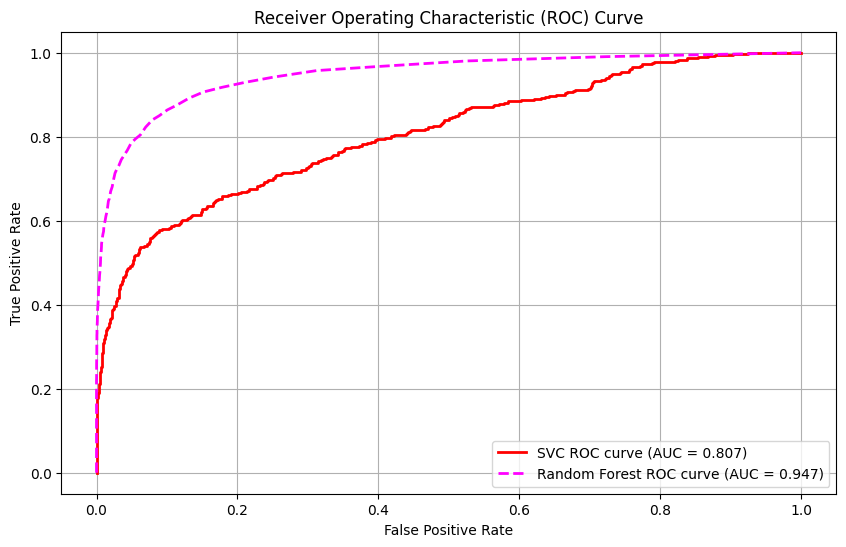

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_SVC, tpr_SVC, color='red', linestyle='-', linewidth=2, label=f'SVC ROC curve (AUC = {roc_auc_svc:.3f})')
plt.plot(fpr_rf, tpr_rf, color='magenta', linestyle='--', linewidth=2, label=f'Random Forest ROC curve (AUC = {roc_auc_rf:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


and if I want to divide the data into groups that have different probability time to disrupt? For examples, the data that a probability of 90% and 80% to disrupt is found between 0 and 10 ms before, another 10 to 20 ms... do it up to 100 ms

   prob_disrupt_0_to_10ms  prob_disrupt_10_to_20ms  prob_disrupt_20_to_30ms
0                       0                        1                        0
1                       1                        0                        0
2                       1                        0                        0
3                       0                        1                        0
4                       0                        1                        0


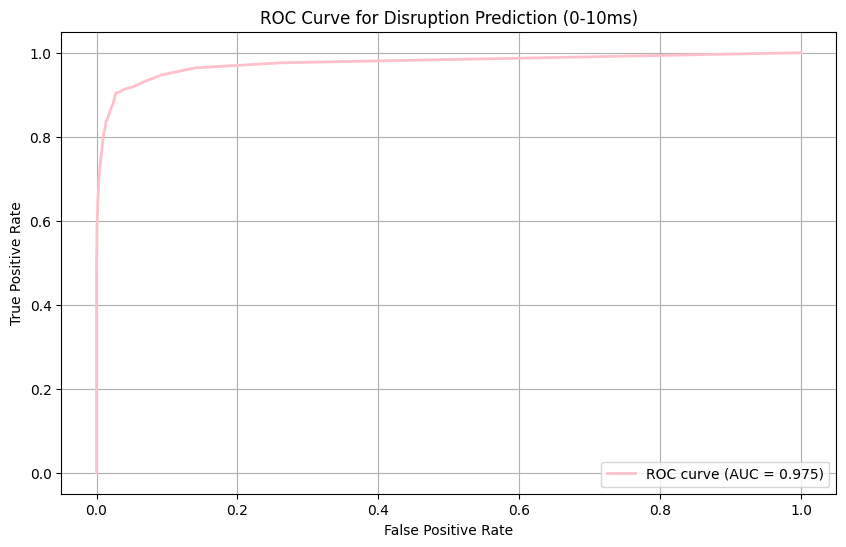

ROC Curve Data for prob_disrupt_0_to_10ms:
      fpr_rf    tpr_rf  threshold
0   0.000000  0.000000        inf
5   0.000000  0.369305       0.96
10  0.000065  0.414868       0.89
15  0.000065  0.450839       0.81
20  0.000065  0.477218       0.75
25  0.000130  0.496403       0.67
30  0.000195  0.520384       0.62
35  0.000521  0.544365       0.56
40  0.000586  0.585132       0.50
45  0.001108  0.604317       0.44
50  0.001759  0.642686       0.39
55  0.002867  0.676259       0.34
60  0.003974  0.709832       0.29
65  0.005864  0.745803       0.24
70  0.008926  0.791367       0.18
75  0.015050  0.839329       0.13
80  0.027298  0.904077       0.08
85  0.092254  0.947242       0.03


In [13]:
# Now I group features
temporal_features = ['time', 'time_until_disrupt']
plasma_magnetic_properties = ['Greenwald_fraction', 'Mirnov_norm_btor', 'Te_peaking_ECE', 'beta_p', 'q95']
control_shape_variables = ['ip_error_normalized', 'kappa', 'li', 'lower_gap', 'n_equal_1_normalized', 'z_error']
other_diagnostics = ['radiated_fraction', 'v_loop']
shot_information = ['shot']

features = plasma_magnetic_properties + control_shape_variables + other_diagnostics
data_dict = {key: data[key].flatten() if data[key].ndim > 1 else data[key] for key in (features + temporal_features + shot_information)}
df = pd.DataFrame(data_dict)
df = df.dropna(subset=['time_until_disrupt'])

# Now I define the time ranges for disruption probabilities
time_ranges = [(0, 0.01), (0.01, 0.02), (0.02, 0.03)]  # 0-10ms,...

# Labels for each time range (1/0 = Y/N disrupt within this range)
for i, (start, end) in enumerate(time_ranges):
    df[f'prob_disrupt_{start*1000:.0f}_to_{end*1000:.0f}ms'] = df['time_until_disrupt'].apply(lambda x: 1 if start <= x < end else 0)

print(df[[f'prob_disrupt_{start*1000:.0f}_to_{end*1000:.0f}ms' for start, end in time_ranges]].head())

# train also separate model for each time intervals

# Example (0-10 ms)
target_label = 'prob_disrupt_0_to_10ms'

X = df[features]
y = df[target_label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_prob = rfc.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='pink', linewidth=2, label=f'ROC curve (AUC = {roc_auc_rf:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Disruption Prediction (0-10ms)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Again for (10-20ms, 20-30ms) by changing the label and retraining the model
roc_df = pd.DataFrame({
    'fpr_rf': fpr_rf,
    'tpr_rf': tpr_rf,
    'threshold': thresholds
})
roc_df_filtered = roc_df.iloc[::5]
print(f"ROC Curve Data for {target_label}:")
print(roc_df_filtered)


Similarly as before:

Data in group 0 to 10 ms: 2056 out of 78829 (2.61%)
Data in group 10 to 20 ms: 1957 out of 78829 (2.48%)
Data in group 20 to 30 ms: 1946 out of 78829 (2.47%)
Data in group 30 to 40 ms: 1935 out of 78829 (2.45%)
Data in group 40 to 50 ms: 1886 out of 78829 (2.39%)
Data in group 50 to 60 ms: 1845 out of 78829 (2.34%)
Data in group 60 to 70 ms: 1852 out of 78829 (2.35%)
Data in group 70 to 80 ms: 2004 out of 78829 (2.54%)
Data in group 80 to 90 ms: 1851 out of 78829 (2.35%)
Data in group 90 to 100 ms: 1814 out of 78829 (2.30%)


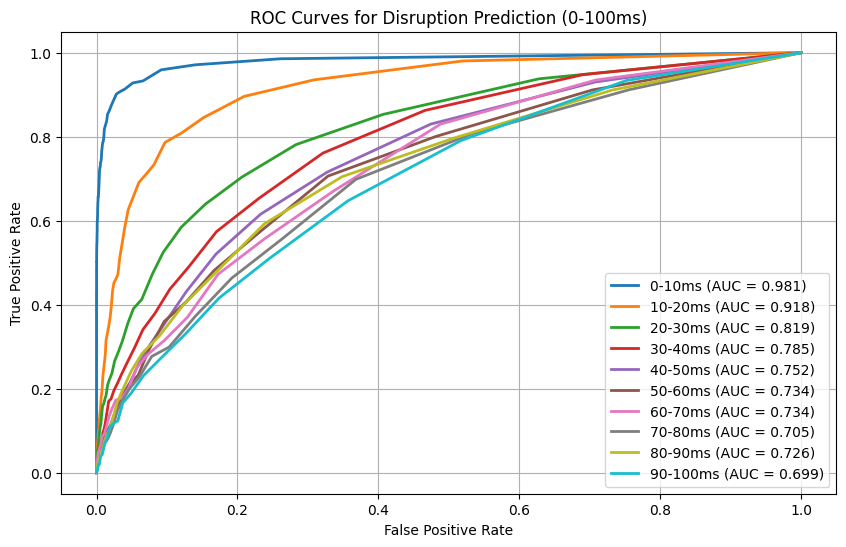

ROC Curve Data for 0 to 10 ms:
      fpr_rf    tpr_rf  threshold
0   0.000000  0.000000        inf
5   0.000000  0.352518       0.96
10  0.000000  0.400480       0.90
15  0.000065  0.438849       0.83
20  0.000065  0.460432       0.76
25  0.000130  0.494005       0.70
30  0.000195  0.522782       0.62
35  0.000391  0.544365       0.56
40  0.000717  0.582734       0.51
45  0.001173  0.623501       0.45
50  0.001955  0.649880       0.38
55  0.002932  0.702638       0.33
60  0.004821  0.726619       0.28
65  0.006645  0.769784       0.23
70  0.009056  0.815348       0.18
75  0.014529  0.848921       0.13
80  0.029904  0.906475       0.08
85  0.089778  0.956835       0.03
ROC Curve Data for 10 to 20 ms:
      fpr_rf    tpr_rf  threshold
0   0.000000  0.000000        inf
5   0.000130  0.014045       0.67
10  0.000389  0.028090       0.58
15  0.000714  0.056180       0.52
20  0.001493  0.084270       0.47
25  0.002206  0.103933       0.42
30  0.004088  0.143258       0.37
35  0.007203  0.188

In [14]:
temporal_features = ['time', 'time_until_disrupt']
plasma_magnetic_properties = ['Greenwald_fraction', 'Mirnov_norm_btor', 'Te_peaking_ECE', 'beta_p', 'q95']
control_shape_variables = ['ip_error_normalized', 'kappa', 'li', 'lower_gap', 'n_equal_1_normalized', 'z_error']
other_diagnostics = ['radiated_fraction', 'v_loop']
shot_information = ['shot']

features = plasma_magnetic_properties + control_shape_variables + other_diagnostics

data_dict = {key: data[key].flatten() if data[key].ndim > 1 else data[key] for key in (features + temporal_features + shot_information)}

df = pd.DataFrame(data_dict)
df = df.dropna(subset=['time_until_disrupt'])

time_ranges = [(i/1000, (i+10)/1000) for i in range(0, 100, 10)]  

for i, (start, end) in enumerate(time_ranges):
    df[f'prob_disrupt_{int(start*1000)}_to_{int(end*1000)}ms'] = df['time_until_disrupt'].apply(lambda x: 1 if start <= x < end else 0)

for start, end in time_ranges:
    label = f'prob_disrupt_{int(start*1000)}_to_{int(end*1000)}ms'
    count_in_group = df[label].sum()
    total_data = len(df)
    print(f"Data in group {int(start*1000)} to {int(end*1000)} ms: {count_in_group} out of {total_data} ({(count_in_group / total_data) * 100:.2f}%)")
plt.figure(figsize=(10, 6))

for i, (start, end) in enumerate(time_ranges):
    target_label = f'prob_disrupt_{int(start*1000)}_to_{int(end*1000)}ms'

    X = df[features]
    y = df[target_label]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(X_train, y_train)

    y_prob = rfc.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_prob)
    roc_auc_rf = auc(fpr_rf, tpr_rf)

    plt.plot(fpr_rf, tpr_rf, linewidth=2, label=f'{int(start*1000)}-{int(end*1000)}ms (AUC = {roc_auc_rf:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Disruption Prediction (0-100ms)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

for i, (start, end) in enumerate(time_ranges):
    target_label = f'prob_disrupt_{int(start*1000)}_to_{int(end*1000)}ms'

    X = df[features]
    y = df[target_label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(X_train, y_train)

    y_prob = rfc.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_prob)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    roc_df = pd.DataFrame({
        'fpr_rf': fpr_rf,
        'tpr_rf': tpr_rf,
        'threshold': thresholds
    })
    roc_df_filtered = roc_df.iloc[::5]
    print(f"ROC Curve Data for {int(start*1000)} to {int(end*1000)} ms:")
    print(roc_df_filtered)


and now I want to consider only the data that in a certain range have at least 80% probability of disruption

Data in group 0 to 10 ms: 1626 out of 78829 (2.06%)
Data in group 10 to 20 ms: 1566 out of 78829 (1.99%)
Data in group 20 to 30 ms: 1548 out of 78829 (1.96%)
Data in group 30 to 40 ms: 1544 out of 78829 (1.96%)
Data in group 40 to 50 ms: 1488 out of 78829 (1.89%)
Data in group 50 to 60 ms: 1468 out of 78829 (1.86%)
Data in group 60 to 70 ms: 1470 out of 78829 (1.86%)
Data in group 70 to 80 ms: 1635 out of 78829 (2.07%)
Data in group 80 to 90 ms: 1474 out of 78829 (1.87%)
Data in group 90 to 100 ms: 1438 out of 78829 (1.82%)


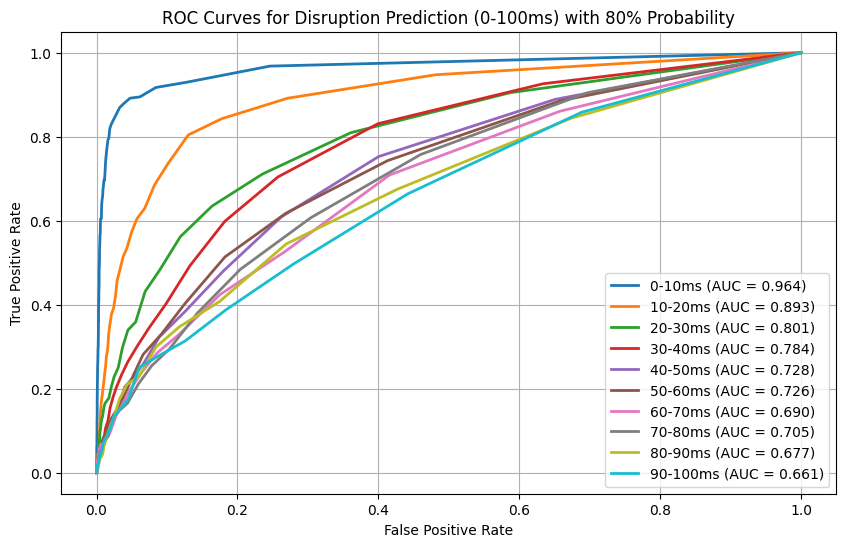

ROC Curve Data for 0 to 10 ms with 80% Probability:
      fpr_rf    tpr_rf  threshold
0   0.000000  0.000000        inf
5   0.000388  0.041401       0.92
10  0.000777  0.098726       0.86
15  0.001424  0.187898       0.81
20  0.002006  0.264331       0.76
25  0.002653  0.324841       0.71
30  0.002977  0.385350       0.65
35  0.003365  0.414013       0.60
40  0.003818  0.449045       0.55
45  0.004207  0.490446       0.49
50  0.004595  0.522293       0.44
55  0.005307  0.592357       0.37
60  0.006278  0.624204       0.32
65  0.007960  0.678344       0.27
70  0.009513  0.719745       0.22
75  0.013396  0.783439       0.16
80  0.019933  0.828025       0.11
85  0.039671  0.894904       0.06
90  0.230585  0.977707       0.01
ROC Curve Data for 10 to 20 ms with 80% Probability:
      fpr_rf    tpr_rf  threshold
0   0.000000  0.000000        inf
5   0.000323  0.013986       0.59
10  0.000840  0.020979       0.48
15  0.001744  0.038462       0.42
20  0.002778  0.062937       0.37
25  0.00458

In [15]:
temporal_features = ['time', 'time_until_disrupt']
plasma_magnetic_properties = ['Greenwald_fraction', 'Mirnov_norm_btor', 'Te_peaking_ECE', 'beta_p', 'q95']
control_shape_variables = ['ip_error_normalized', 'kappa', 'li', 'lower_gap', 'n_equal_1_normalized', 'z_error']
other_diagnostics = ['radiated_fraction', 'v_loop']
shot_information = ['shot']
features = plasma_magnetic_properties + control_shape_variables + other_diagnostics


data_dict = {key: data[key].flatten() if data[key].ndim > 1 else data[key] for key in (features + temporal_features + shot_information)}
df = pd.DataFrame(data_dict)
df = df.dropna(subset=['time_until_disrupt'])

time_ranges = [(i/1000, (i+10)/1000) for i in range(0, 100, 10)] 
probability_threshold = 0.8 

for i, (start, end) in enumerate(time_ranges):
    df[f'prob_disrupt_{int(start*1000)}_to_{int(end*1000)}ms'] = df['time_until_disrupt'].apply(
        lambda x: 1 if start <= x < end and np.random.rand() <= probability_threshold else 0
    )

for start, end in time_ranges:
    label = f'prob_disrupt_{int(start*1000)}_to_{int(end*1000)}ms'
    count_in_group = df[label].sum()
    total_data = len(df)
    print(f"Data in group {int(start*1000)} to {int(end*1000)} ms: {count_in_group} out of {total_data} ({(count_in_group / total_data) * 100:.2f}%)")
plt.figure(figsize=(10, 6))

for i, (start, end) in enumerate(time_ranges):
    target_label = f'prob_disrupt_{int(start*1000)}_to_{int(end*1000)}ms'

    X = df[features]
    y = df[target_label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(X_train, y_train)
    y_prob = rfc.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_prob)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    plt.plot(fpr_rf, tpr_rf, linewidth=2, label=f'{int(start*1000)}-{int(end*1000)}ms (AUC = {roc_auc_rf:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves for Disruption Prediction (0-100ms) with {int(probability_threshold*100)}% Probability')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

for i, (start, end) in enumerate(time_ranges):
    target_label = f'prob_disrupt_{int(start*1000)}_to_{int(end*1000)}ms'
    X = df[features]
    y = df[target_label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(X_train, y_train)
    y_prob = rfc.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_prob)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    roc_df = pd.DataFrame({
        'fpr_rf': fpr_rf,
        'tpr_rf': tpr_rf,
        'threshold': thresholds
    })
    roc_df_filtered = roc_df.iloc[::5]
    print(f"ROC Curve Data for {int(start*1000)} to {int(end*1000)} ms with {int(probability_threshold*100)}% Probability:")
    print(roc_df_filtered)
